In [1]:
import matplotlib.pyplot as plt
import numpy as np
import collections
import pprint

In [2]:
percentages = [1,3,5,7,10]
files = ["linear_lr_results_%d.0_percent.npy" %p for p in percentages]

In [3]:
# Dictionary that looks like this:
# key -> percentage, val -> [results of first run, ..., results of fifth run]
# results of nth run = [dict of epoch 1, ..., dict of epoch 5]
data1 = {p: np.load(file, allow_pickle=True) for p, file in zip(percentages, files)}

In [4]:
data2 = collections.defaultdict(dict)
for percentage in data1:
    all_results = data1[percentage]
    for i, run_results in enumerate(all_results):
        if i in [3, 4]: continue     # eliminate results from 4th and 5th run, as they contain zeros. 
        run = "r" + str(i+1)
        data2[percentage][run] = run_results

# Create a dictionary of PRF (precision, recall, f1) data.
prf = collections.defaultdict(dict)
for percentage in data2:
    for run in data2[percentage]:
        prf_run_values = [data2[percentage][run][epoch]["PRF"] for epoch in range(5)]
        prf[percentage][run] = prf_run_values
        
# Get the F1 scores in a dict of arrays. The shape of the array should be (3, 5), representing 3 runs of 5 epochs each.
all_f1_pos = {}
all_f1_neg = {}
for percent in prf:
    pos_run = []
    neg_run = []
    for run in prf[percent]:
        arr_dics = prf[percent][run]
        pos_epochs = []
        neg_epochs = []
        for d in arr_dics:
            pos_epochs.append(d["Positive"][2])
            neg_epochs.append(d["Negative"][2])
        pos_run.append(pos_epochs)
        neg_run.append(neg_epochs)
    all_f1_pos[percent] = np.array(pos_run)
    all_f1_neg[percent] = np.array(neg_run)

In [5]:
# I want to take the average, over the three runs, of the F1 scores per epoch. 
# In other words, I want to calculate avg_f1_score_epoch_1 = (sum of f1 scores of epoch 1) / 3. Same for the rest.
avg_f1_scores_pos = {pctg: np.mean(scores_per_epoch, axis=0) for pctg, scores_per_epoch in all_f1_pos.items()}
avg_f1_scores_neg = {pctg: np.mean(scores_per_epoch, axis=0) for pctg, scores_per_epoch in all_f1_neg.items()}
avg_f1_scores = {"Positive": avg_f1_scores_pos, "Negative": avg_f1_scores_neg}
# Get the standard deviation as well.
std_f1_scores_pos = {pctg: np.std(scores_per_epoch, axis=0) for pctg, scores_per_epoch in all_f1_pos.items()}
std_f1_scores_neg = {pctg: np.std(scores_per_epoch, axis=0) for pctg, scores_per_epoch in all_f1_neg.items()}
std_f1_scores = {"Positive": std_f1_scores_pos, "Negative": std_f1_scores_neg}

In [6]:
std_f1_scores["Positive"]

{1: array([0.01918935, 0.02717623, 0.03227606, 0.04492879, 0.03714492]),
 3: array([0.03241123, 0.10199853, 0.03224217, 0.04232071, 0.0461748 ]),
 5: array([0.01197947, 0.02679075, 0.00990635, 0.0013279 , 0.0035311 ]),
 7: array([0.04864688, 0.02614845, 0.01490556, 0.02244414, 0.02345703]),
 10: array([0.02519998, 0.0105459 , 0.01807348, 0.02005459, 0.02005459])}

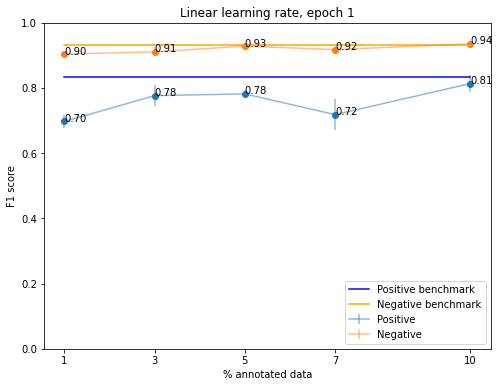

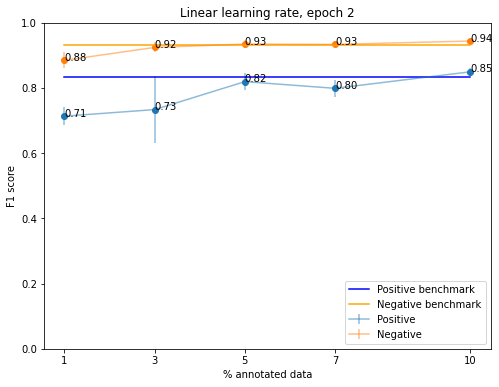

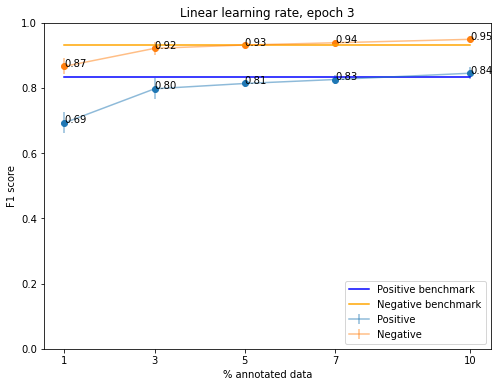

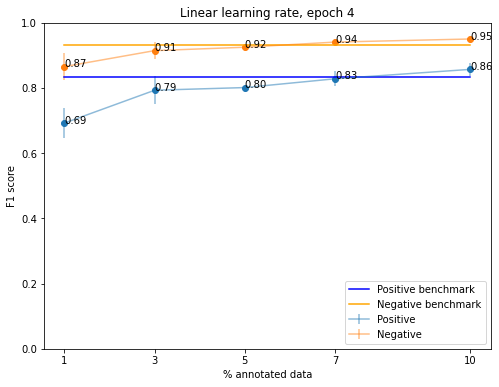

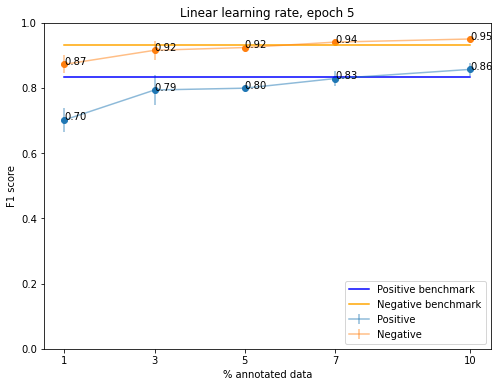

In [7]:
d = avg_f1_scores
d2 = std_f1_scores
for epoch in range(5):
    f1_pos = [d["Positive"][percentage][epoch] for percentage in percentages]
    f1_neg = [d["Negative"][percentage][epoch] for percentage in percentages]
    err_pos = [d2["Positive"][percentage][epoch] for percentage in percentages]
    err_neg = [d2["Negative"][percentage][epoch] for percentage in percentages]
    acc_benchmark = .904
    f1_benchmark_pos = .832
    f1_benchmark_neg = .932
    accuracy = [0.773, 0.895, 0.926]
    plt.figure(figsize=(8,6))
    plt.ylabel("F1 score")
    plt.xlabel("% annotated data")
    plt.ylim(0,1)
    plt.xticks(percentages)
    plt.scatter(percentages, f1_pos)
    for i, j in zip(percentages, f1_pos):
            plt.annotate("%.2f" %j, (i, j))
    plt.errorbar(percentages, f1_pos, yerr = err_pos, alpha=.5, label="Positive")
    
    plt.scatter(percentages, f1_neg)
    for i, j in zip(percentages, f1_neg):
            plt.annotate("%.2f" %j, (i, j))
    plt.errorbar(percentages, f1_neg, yerr = err_neg, alpha=.5, label="Negative")
    plt.plot(percentages, [f1_benchmark_pos for _ in percentages], c="blue", label="Positive benchmark")
    plt.plot(percentages, [f1_benchmark_neg for _ in percentages], c="orange",label="Negative benchmark")
    plt.legend(loc="lower right")
    plt.title("Linear learning rate, epoch %d" %(epoch+1))
    plt.savefig("f1_scores_linear_lr_epoch %d" %(epoch+1))